In [109]:
%matplotlib inline 

import Quandl
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import statsmodels.tsa.stattools as stats

import sys
from os import listdir
from os.path import isfile, join



In [53]:
def read_csv_data(filename):
    """
    Read a csv file from disk
    """
    return pd.read_csv(filename)
    
def write_csv_data(df, filename, row_names=False, col_names=True):
    """
    Write a csv file to disk
    """
    df.to_csv(filename, index=row_names, header=col_names)    

In [110]:
GOLD = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/LBMA-GOLD.csv')
SILVER = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/LBMA-SILVER.csv')
PLAT = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/LPPM-PLAT.csv')
INDEX_DJIA = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/YAHOO-INDEX_DJIA.csv')
INDEX_HSI = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/YAHOO-INDEX_HSI.csv')
INDEX_IBEX = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/YAHOO-INDEX_IBEX.csv')
INDEX_N225 = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/YAHOO-INDEX_N225.csv')
INDEX_SP500 = read_csv_data('/Users/Pablo/Desktop/TFM/Raw_Data/YAHOO-INDEX_SP500.csv')

In [119]:
def order_dataframe(df, col='Date', ascending=True):
    """
    """
    df = df.sort_values(col, ascending=ascending)
    df.index = range(df.shape[0])
    return df

def multiply_df(df, value, cols):
    """
    """
    df[cols] = df[cols].apply(lambda x: x*value)
    return df

def select_rows_by_actual_date(df, min_date):
    """
    """
    rows =  df.Date[df.Date == min_date].index[0]
    rows = df.shape[0] - rows - 1
    df_new = df.tail(rows+1) 
    return order_dataframe(df_new)


def compare_dates(df1, df2):
    """
    """
    equal = True
    for i in  df1.index[::1]:
        if df1.Date[i] != df2.Date[i]:
            print("1 - Different dates at", i)
            print(df1.Date[i], df2.Date[i])
            equal = False

    return equal

def get_index_of_different_dates(df1, df2):
    """
    """
    values = df1.Date.isin(df2.Date)
    for i in range(len(values)): 
        if values[i] == False:
            indices =  df1.Date[i].index()
            
    return values, indices

def align_date_in_dataframe(df1, df2):
    """
    Align second dataframe respect to one using Date column
    """
    
    if check_dataframes_alignment(df1, df2) == True:
        return     
    
    values = df2.Date.isin(df1.Date)
    for i in range(len(values)): 
        if values[i] == False:
            df2 = df2[df2.Date != df2.Date[i]]

    values = df1.Date.isin(df2.Date)        
    for i in range(len(values)): 
        if values[i] == False:
            line = pd.DataFrame({"Date": df1.Date[i], "Open": -1, "High": -1, "Low": -1, "Close": -1, "Volume": -1, "Adjusted Close": -1}, index=[i])    
            df2 = df2.append(line, ignore_index=True)

    df2 = df2[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close']]
            
    df2 = order_dataframe(df2)
    df2.index = range(df2.shape[0])
    df1.index = range(df1.shape[0])
    return df2

def check_dataframes_alignment(df1, df2):
    """
    Checks whether two dataframes are aligned by date
    """
    values1 = df1.Date.isin(df2.Date)
    values2 = df2.Date.isin(df1.Date)
    if (values1[values1 == False].shape[0] > 0) or (values2[values2 == False].shape[0]):
        return False
    else:
        return True

    
def toTimestamp(d):
    """
    """
    return calendar.timegm(d.timetuple())

def fill_gaps_with_interpolation(df_old, df_new, cols, kind=['linear'], chart=False, gap_value=-1, verbose=True):
    """
    Undertakes interpolation to fill up missing values
    """
    for col in cols:
        if verbose: print("Interpolating column %s..." % (col))
            
        x0 = []
        for i in range(df_old.shape[0]):
            date_object = datetime.strptime(df_old.Date[i], '%Y-%m-%d')
            x0.append(toTimestamp(date_object))

        y0 = df_old.loc[:,(col)].as_matrix() #np.random.random(21)
 
        if(chart == True):
            plt.plot(x0, y0, 'o', label='Data')

        # Array with points in between those of the data set for interpolation.
        x = []
        for i in range(INDEX_IBEX_new.shape[0]):
            date_object = datetime.strptime(df_new.Date[i], '%Y-%m-%d')
            x.append(toTimestamp(date_object))

        # Available options for interp1d ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 10)
        f = interp1d(x0, y0, kind='linear')    # interpolation function
        
        indices = df_new[col][df_new[col] == gap_value]        
        for i in indices.index:
            date = df_new.Date[i]
            df_new.loc[:,(col)].iloc[i] = f(toTimestamp(datetime.strptime(date, '%Y-%m-%d')))  

        if(chart == True):
            plt.plot(x, f(x), label='linear')      # plot of interpolated data
            plt.legend()
            plt.show()

    return df_new

In [120]:
GOLD = order_dataframe(GOLD)
SILVER = order_dataframe(SILVER)
PLAT = order_dataframe(PLAT)
INDEX_DJIA = order_dataframe(INDEX_DJIA)
#INDEX_DJIA no need to multiply it
INDEX_HSI = order_dataframe(INDEX_HSI)
#INDEX_HSI no need to multiply it
INDEX_IBEX = order_dataframe(INDEX_IBEX)
#INDEX_IBEX no need to multiply it
INDEX_N225 = order_dataframe(INDEX_N225)
#INDEX_N225 no need to multiply it
INDEX_SP500= order_dataframe(INDEX_SP500)
#INDEX_SP500 no need to multiply it

In [121]:
min_date = '1993-04-12'
INDEX_DJIA_new = select_rows_by_actual_date(INDEX_DJIA, min_date)
INDEX_HSI_new = select_rows_by_actual_date(INDEX_HSI, min_date)
INDEX_IBEX_new = select_rows_by_actual_date(INDEX_IBEX, min_date)
INDEX_N225_new = select_rows_by_actual_date(INDEX_N225, min_date)
INDEX_SP500_new = select_rows_by_actual_date(INDEX_SP500, min_date)

In [123]:
INDEX_HSI_new = align_date_in_dataframe(INDEX_DJIA_new, INDEX_HSI_new)
INDEX_IBEX_new = align_date_in_dataframe(INDEX_DJIA_new, INDEX_IBEX_new)
INDEX_N225_new = align_date_in_dataframe(INDEX_DJIA_new, INDEX_N225_new)

In [124]:
print INDEX_DJIA_new.shape
print INDEX_HSI_new.shape
print INDEX_IBEX_new.shape
print INDEX_N225_new.shape
print INDEX_SP500_new.shape

(5800, 7)
(5800, 7)
(5800, 7)
(5800, 7)
(5800, 7)


In [133]:
cols = ['Open','High','Low','Close','Volume','Adjusted Close']
INDEX_HSI_new = fill_gaps_with_interpolation(INDEX_HSI, INDEX_HSI_new, cols, ['linear'], False, 0.0)
INDEX_IBEX_new = fill_gaps_with_interpolation(INDEX_IBEX, INDEX_IBEX_new, cols, ['linear'], False, 0.0)
INDEX_N225_new = fill_gaps_with_interpolation(INDEX_N225, INDEX_N225_new, cols, ['linear'], False, 0.0)

('Interpolating colunm ', 'Open', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'High', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Low', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Close', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Volume', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Adjusted Close', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Open', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'High', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Low', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Close', '...')
Calculating function...
Calculating function...
('Interpolating colunm ', 'Volume', '...')
Calculating function...
Calculating function...
('Inter

In [126]:
cols = ['Open','High','Low','Close','Volume','Adjusted Close']
INDEX_HSI_new = fill_gaps_with_interpolation(INDEX_HSI, INDEX_HSI_new, cols, ['linear'], False)
INDEX_IBEX_new = fill_gaps_with_interpolation(INDEX_IBEX, INDEX_IBEX_new, cols, ['linear'], False)
INDEX_N225_new = fill_gaps_with_interpolation(INDEX_N225, INDEX_N225_new, cols, ['linear'], False)

Total score for 1 is 2  


In [100]:
def has_gaps(df, cols, gap_value=-1):
    """
    """
    for col in cols:
        gaps = df.loc[:,(col)][df.loc[:,(col)] == gap_value].values.shape[0]
        if gaps > 0:
            return True

    return False

In [136]:
write_csv_data(INDEX_DJIA_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA_new.csv')
write_csv_data(INDEX_SP500_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500_new.csv')
write_csv_data(INDEX_HSI_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI_new.csv')
write_csv_data(INDEX_IBEX_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX_new.csv')
write_csv_data(INDEX_N225_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225_new.csv')

In [134]:
print has_gaps(INDEX_DJIA_new, cols, 0.0)
print has_gaps(INDEX_SP500_new, cols, 0.0)
print has_gaps(INDEX_HSI_new, cols, 0.0)
print has_gaps(INDEX_IBEX_new, cols, 0.0)
print has_gaps(INDEX_N225_new, cols, 0.0)

False
False
True
True
True


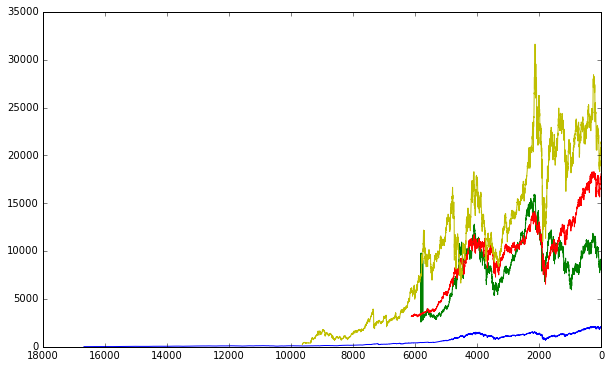

In [257]:
#acf = autocorrelation(INDEX_IBEX['Close'], 100, False)
#ccf = crosscorrelation(INDEX_IBEX['Close'], INDEX_IBEX['Close'], False)
#
#plt.plot(acf1)
#plt.plot(acf2)
#plt.show()

# make a new figure
plt.hold(True)
# Set figure width to 12 and height to 9
fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(INDEX_SP500['Close'], 'b')
plt.plot(INDEX_IBEX['Close'], 'g')
plt.plot(INDEX_DJIA ['Close'], 'r')
plt.plot(INDEX_HSI['Close'], 'y')
plt.hold(True)
plt.gca().invert_xaxis()
plt.show()

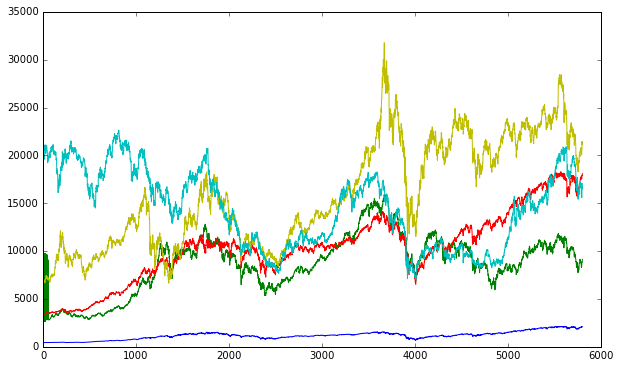

In [127]:
# Set figure width to 12 and height to 9
fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(INDEX_SP500_new['Close'], 'b')
plt.plot(INDEX_IBEX_new['Close'], 'g')
plt.plot(INDEX_DJIA_new['Close'], 'r')
plt.plot(INDEX_HSI_new['Open'], 'y')
plt.plot(INDEX_N225_new['Open'], 'c')